<a href="https://colab.research.google.com/github/Maya-Poghosyan/coding-challenge-FA24/blob/main/Submissions/MayaPoghosyan_VDSApplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Sensitive Clustering of COVID-19 Responses

**Open in Colab to see the interactive visual at the end! :)** <br>
May be helpful as country codes are used later in the data: https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm

In [ ]:
!pip install tslearn
!pip install geopandas
!pip install geodatasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
import tslearn
import numpy as np
import geopandas as gpd
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import geodatasets
import plotly.express as px

In [ ]:
df = pd.read_csv("/content/OxCGRT_compact_national_v1.csv")
df.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,V3_Vaccine Financial Support (summary),V4_Mandatory Vaccination (summary),ConfirmedCases,ConfirmedDeaths,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0


Let's see how many/which unique countries are represented.

In [ ]:
unique_countries = df['CountryCode'].unique()
print(unique_countries)
print(len(unique_countries))

['ABW' 'AFG' 'AGO' 'ALB' 'AND' 'ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL'
 'BEN' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA'
 'BRB' 'BRN' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD'
 'COG' 'COL' 'CPV' 'CRI' 'CUB' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM'
 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'FRO' 'GAB'
 'GBR' 'GEO' 'GHA' 'GIN' 'GMB' 'GRC' 'GRL' 'GTM' 'GUM' 'GUY' 'HKG' 'HND'
 'HRV' 'HTI' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM'
 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KOR' 'KWT' 'LAO' 'LBN' 'LBR'
 'LBY' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAC' 'MAR' 'MCO' 'MDA' 'MDG'
 'MEX' 'MLI' 'MLT' 'MMR' 'MNG' 'MOZ' 'MRT' 'MUS' 'MWI' 'MYS' 'NAM' 'NER'
 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'PNG'
 'POL' 'PRI' 'PRT' 'PRY' 'PSE' 'QAT' 'RKS' 'ROU' 'RUS' 'RWA' 'SAU' 'SDN'
 'SEN' 'SGP' 'SLB' 'SLE' 'SLV' 'SMR' 'SOM' 'SRB' 'SSD' 'SUR' 'SVK' 'SVN'
 'SWE' 'SWZ' 'SYC' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'T

In [ ]:
print(df.shape)

(202760, 56)


We have a lot of both *discrete flag variables* and *numerical variables*, but because we will be using K-means clustering later and clustering suffers from the <a href = "https://www.datacamp.com/blog/curse-of-dimensionality-machine-learning">curse of dimensionality</a>, we'll just be using the numerical indexes for clustering.

In [ ]:
included_columns = ["CountryCode", "Date", "StringencyIndex_Average", "GovernmentResponseIndex_Average",
                   "ContainmentHealthIndex_Average", "EconomicSupportIndex"]
df = df[included_columns]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.set_index(['CountryCode', 'Date'])
df.tail()

StringencyIndex_Average  \
CountryCode Date                                  
ZWE         2022-12-27                    29.48   
            2022-12-28                    29.48   
            2022-12-29                    29.48   
            2022-12-30                    29.48   
            2022-12-31                    29.48   

                        GovernmentResponseIndex_Average  \
CountryCode Date                                          
ZWE         2022-12-27                            36.44   
            2022-12-28                            36.44   
            2022-12-29                            36.44   
            2022-12-30                            36.44   
            2022-12-31                            36.44   

                        ContainmentHealthIndex_Average  EconomicSupportIndex  
CountryCode Date                                                              
ZWE         2022-12-27                           41.65                   0.0  
            2022-12-28                           41.65                   0.0  
            2022-12-29                           41.65                   0.0  
            2022-12-30                           41.65                   0.0  
            2022-12-31                           41.65                   0.0

Now we have a time series for every feature for every country -- this is great for visualization.

In [ ]:
print(type(df.loc["ZWE", "ContainmentHealthIndex_Average"])) # series data!

<class 'pandas.core.series.Series'>


In [ ]:
len(df.loc["CHN", "ContainmentHealthIndex_Average"])

1096

In [ ]:
features = ["StringencyIndex_Average", "GovernmentResponseIndex_Average","ContainmentHealthIndex_Average", "EconomicSupportIndex"]
for country in unique_countries:
  for feature in features:
    if (len(df.loc[country, feature])) != 1096:
      print("Uneven spans of time.") # doesn't print, so we know they all span the same number of dates, meaning we can use euclidean distance

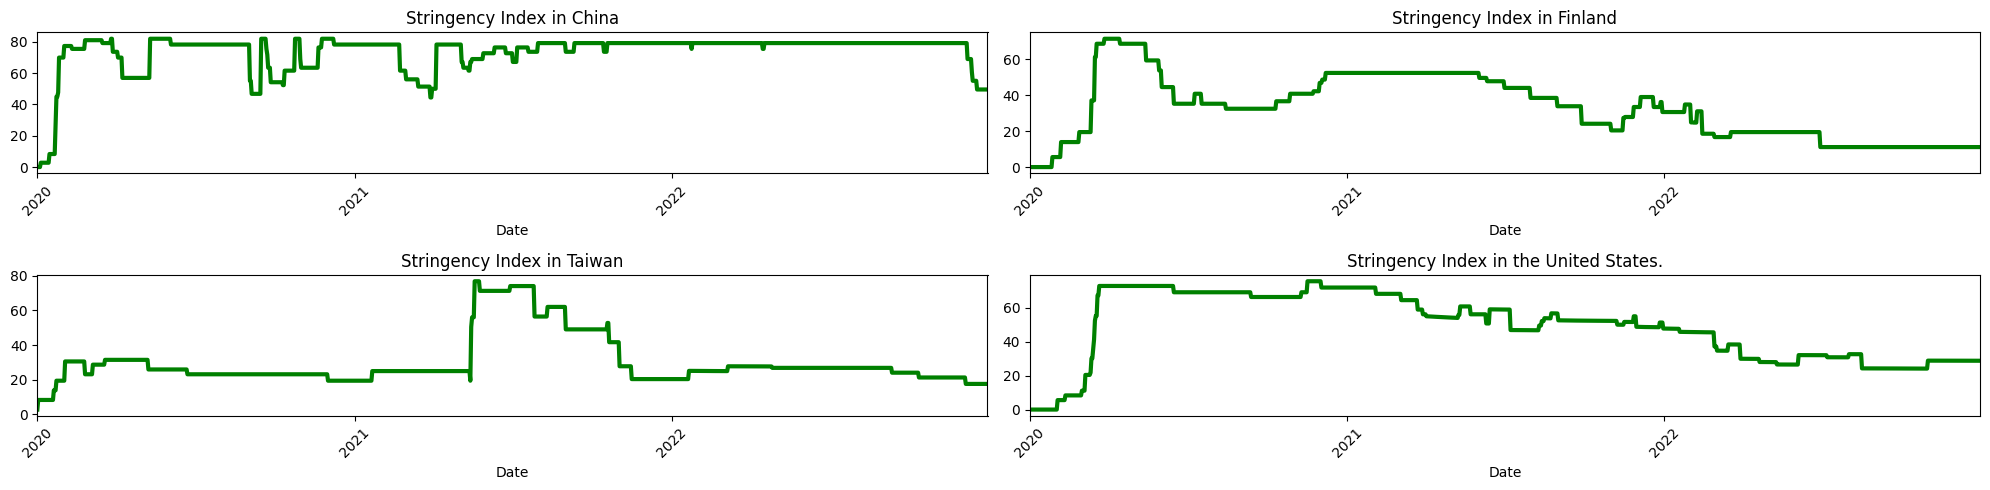

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

df.loc['CHN', 'StringencyIndex_Average'].plot(ax=axes[0, 0], linewidth=3, color = "green")
axes[0, 0].set_title('Stringency Index in China')

df.loc['FIN', 'StringencyIndex_Average'].plot(ax=axes[0, 1], linewidth = 3, color = "green")
axes[0, 1].set_title('Stringency Index in Finland')

df.loc['TWN', 'StringencyIndex_Average'].plot(ax=axes[1, 0], linewidth = 3, color = "green")
axes[1, 0].set_title('Stringency Index in Taiwan')

df.loc['USA', 'StringencyIndex_Average'].plot(ax=axes[1, 1], linewidth = 3, color = "green")
axes[1, 1].set_title('Stringency Index in the United States.')

# iterate through every subplot
for ax in axes.flatten():
    # set ticks on x-axis to be the start of new years in the timespan of the data
    ax.xaxis.set_major_locator(mdates.YearLocator())
    # format ticks so they only display the year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # turn off minor ticks that would display midway points with month labels
    ax.minorticks_off()
    # rotate the x-labels for easier viewing
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

Now that we've been able to visualize this data, we should reformat it into a format more compatible with our clustering tasks.

In [ ]:
# Reset so we no longer have a multi-index with both country code and date
df_reset = df.reset_index()

# Use pivoting to create 4 DataFrames, one for each feature, where the columns represent the dates
# at different times.

stringency_pivot = df_reset.pivot(index='CountryCode', columns='Date', values='StringencyIndex_Average')
economic_pivot = df_reset.pivot(index='CountryCode', columns='Date', values='EconomicSupportIndex')
containment_pivot = df_reset.pivot(index='CountryCode', columns='Date', values='ContainmentHealthIndex_Average')
govt_response_pivot = df_reset.pivot(index='CountryCode', columns='Date', values='GovernmentResponseIndex_Average')

# Concatenate the dataframes "side-by-side", making one large DataFrame where each row is ID'd by a country code and has a column representing feature
# data at every date for every feature
country_time_series_df = pd.concat([stringency_pivot, economic_pivot, containment_pivot, govt_response_pivot], axis=1)

# Fill missing values with forward fill
country_time_series_df = country_time_series_df.ffill()

country_time_series_df

Date,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
CountryCode,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.17,29.17,29.17,29.17,29.17,29.17,29.17,29.17,29.17,29.17
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.33,8.33,8.33,8.33,8.33,8.33,8.33,8.33,8.33,8.33
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.28,27.28,27.28,27.28,27.28,27.28,27.28,27.28,27.28,27.28
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.71,17.71,17.71,17.71,17.71,17.71,17.71,17.71,17.71,17.71
AND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.17,29.17,29.17,29.17,29.17,29.17,29.17,29.17,29.17,29.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VUT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.50,12.50,12.50,12.50,12.50,12.50,12.50,12.50,12.50,12.50
YEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.83,5.83,5.83,5.83,5.83,5.83,5.83,5.83,5.83,5.83
ZAF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.88,21.88,21.88,21.88,21.88,21.88,21.88,21.88,21.88,21.88


Time for clustering -- for the sake of managing computational complexity, we will designate 3 clusters based on the shape/progression of the time series. We will also set our metric to `euclidean` to save time instead of `dtw`.

In [ ]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import warnings
warnings.filterwarnings('ignore')

n_samples = len(country_time_series_df)  # number of countries
n_variables = 4  # Number of time series features per country
n_timestamps = len(country_time_series_df.columns) // n_variables  # number of timestamps per timeseries

# create a 3D array with these dimensions
data_3d = np.zeros((n_samples, n_timestamps, n_variables))

for i in range(n_variables):
    # Calculate start and end indices for each timeseries feature (number of array slots occupied = number of timestamps)
    start_id = i * n_timestamps
    end_id = (i + 1) * n_timestamps

    # extract the actual values of the feature from the dataframe
    var_data = country_time_series_df.iloc[:, start_id:end_id].values
    data_3d[:, :, i] = var_data

# scale -- standard step of preprocessing
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(data_3d)

# time series clustering with TimeSeriesKMeans
n_clusters = 3

# use euclidean distance metric
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=42)

# Fit the model to the scaled time series data and predict the clusters
clusters = model.fit_predict(data_scaled)

# print the cluster results (0, 1, or 2)
print(clusters)

[2 2 2 1 1 1 1 1 0 2 0 1 1 2 1 1 1 1 2 1 1 0 2 1 0 0 1 1 2 1 1 1 0 2 2 2 2
 1 1 1 1 1 1 0 2 2 1 1 1 1 1 1 1 0 2 1 0 1 1 1 1 1 2 2 2 0 1 2 1 1 0 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 0 1 2 2 1 0 1 1 0 1 0 2 0 1 2 1 1 1 0 1 1 1 1 1 2 1
 0 1 2 2 0 2 1 2 0 2 0 1 1 2 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 2
 2 1 0 1 2 1 1 1 1 1 0 2 2 0 1 1 0 1 0 1 0 1 0 0 2 1 1 1 1 1 0 1 2 2 1 1 2]


Now, let's visualize these clusters on the world map using Plotly!

In [ ]:
cluster_data = pd.DataFrame({'country_code': unique_countries,'cluster': clusters})

# create plotly choropleth plot
fig = px.choropleth(
    cluster_data,
    locations='country_code',
    color='cluster',
    hover_name='country_code',
    color_discrete_sequence=px.colors.qualitative.Set2,  # set a discrete color scheme
    projection='natural earth'
)

fig.show()

Above is a map of countries clustered by similarities in how stringently they tackled COVID-19 and how their policy responses shifted over time. Clustering is hard to evaluate as it isn't supervised, but for reasons I'll further describe in the write-up, this grouping does logically make some real-world sense, meaning our clustering was somewhat successful :)